In [27]:
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, date_format, round, when, expr, lit
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
#from google.colab import drive
#drive.mount('/content/drive')


In [28]:
### Initialize a SparkSession named Propwise with a jar config. A different port has also been defined to avoid initialization failures. Change the path for the .jar file to point to the file in your system.
spark=SparkSession.builder.appName('Propwise').config("spark.jars", r"C:\Users\Asad\Documents\Propwise Challenge\postgresql-42.7.6.jar").config("spark.driver.port", "4041").config("spark.ui.port", "4041").getOrCreate()

In [29]:
### The input file is being read. Change the file path to point to your own data file.
#file_path = '/content/drive/MyDrive/Propwise Challenge/transactions-2025-06-07.csv'
file_path = r"C:\Users\Asad\Documents\Propwise Challenge\transactions-2025-06-11.csv"

#The options for read.csv have been defined because there was malformed data where a field had a line break and went to the next, causing parsing issues. It is read correctly with enabling multiline and defining quote and escape characters
df = spark.read.csv(file_path, header=True, inferSchema=True, multiLine= True, quote='"', escape='"')
df_rows = df.count()

In [30]:
df_rows = df.count()
print(df_rows)
df.printSchema()
df.show()

112122
root
 |-- TRANSACTION_NUMBER: string (nullable = true)
 |-- INSTANCE_DATE: timestamp (nullable = true)
 |-- GROUP_EN: string (nullable = true)
 |-- PROCEDURE_EN: string (nullable = true)
 |-- IS_OFFPLAN_EN: string (nullable = true)
 |-- IS_FREE_HOLD_EN: string (nullable = true)
 |-- USAGE_EN: string (nullable = true)
 |-- AREA_EN: string (nullable = true)
 |-- PROP_TYPE_EN: string (nullable = true)
 |-- PROP_SB_TYPE_EN: string (nullable = true)
 |-- TRANS_VALUE: double (nullable = true)
 |-- PROCEDURE_AREA: double (nullable = true)
 |-- ACTUAL_AREA: double (nullable = true)
 |-- ROOMS_EN: string (nullable = true)
 |-- PARKING: string (nullable = true)
 |-- NEAREST_METRO_EN: string (nullable = true)
 |-- NEAREST_MALL_EN: string (nullable = true)
 |-- NEAREST_LANDMARK_EN: string (nullable = true)
 |-- TOTAL_BUYER: integer (nullable = true)
 |-- TOTAL_SELLER: integer (nullable = true)
 |-- MASTER_PROJECT_EN: string (nullable = true)
 |-- PROJECT_EN: string (nullable = true)

+-----

In [31]:
"""Defining a function to clean the data of any null and duplicate records, make the column names more consistent and to correctly parse date and numeric values"""

def transform(df):

  ### Standardize column names by iterating through all the columns, converting them to lower case and replacing spaces with underscores(_)
  for oldCol in df.columns:
    df = df.withColumnRenamed(oldCol, oldCol.lower().replace(' ','_'))

  ### Remove null values and any duplicate rows that may be present in the data
  cleaned_df = df.na.drop(subset=["transaction_number"])
  cleaned_df = cleaned_df.dropDuplicates()

  ### Parse date values that were being read as string by converting to timestamp data type and then splitting the date and time in their own separate columns

  # Convert instance_date column to type timestamp as it was being read as string due to format discrepancies
  cleaned_df = cleaned_df.withColumn('instance_date_timestamp', expr("try_to_timestamp(instance_date, 'yyyy-MM-dd HH:mm:ss')"))

  # Place the date and time in their own new columns
  cleaned_df = cleaned_df.withColumn('date_col', date_format(col('instance_date_timestamp'), 'yyyy-MM-dd'))
  cleaned_df = cleaned_df.withColumn('time_col', date_format(col('instance_date_timestamp'), 'HH:mm:ss'))

  ### Parse numeric columns by ensuring they are of data type 'double' and rounding them to 2 decimal places
  for column in ["trans_value", "procedure_area", "actual_area"]:
    cleaned_df = cleaned_df.withColumn(column, round(col(column).cast('double'),2))

  ### New columns (price_per_sqm, price_per_room, budget_tier, has_parking)
  # Calculating price per sqm by dividing the trans_value by procedure_area and rounding to 2
  cleaned_df = cleaned_df.withColumn('price_per_sqm', round(col('trans_value')/col('procedure_area'),2))
  # Calculating price per sqm by dividing the trans_value by rooms_en (considering Studio to be 1 room) and rounding to 2
  cleaned_df = cleaned_df.withColumn('price_per_room', round(col("trans_value") / when(col("rooms_en") == "Studio", 1).otherwise(expr("try_cast(substr(rooms_en, 1, 1) as int)")), 2))
  # Getting the budget tier (Low, Medium or High budget) by defining ranges for each for the trans_value field
  cleaned_df = cleaned_df.withColumn('budget_tier', when(col("trans_value")<=600000, "Low Budget").when((col("trans_value")>600000) & (col("trans_value")<=2500000), "Medium Budget").otherwise("High Budget"))
  # Creating a new field has_parking which is essentially a flag for whether a property has parking or not
  cleaned_df = cleaned_df.withColumn("has_parking", when(col("parking").isNull(), "NO").otherwise("YES"))
  
  return cleaned_df

In [32]:
""" Funtion to load the cleaned and transformed data into a local PostgreSQL database """

def load(cleaned_df, table_name):
  # PostgreSQL info for the local instance and database to load the data into. Replace with your own database url, username and password
  postgresql_url = r"jdbc:postgresql://localhost:5432/UAE_Real_Estate"
  properties = {
      "user" : "postgres",
      "password" : "123",
      "driver" : "org.postgresql.Driver"
  }

  # Write DataFrame to PostgreSQL table
  cleaned_df.write.jdbc(url=postgresql_url, table=table_name, mode="overwrite", properties=properties)

In [33]:
# Calling the transform and load functions. Replace the table name with the you need.
cleaned_df = transform(df)
load(cleaned_df, "dubai_real_estate_transactions")
cleaned_df_rows = cleaned_df.count()
print(cleaned_df_rows)
cleaned_df.show()

111868
+------------------+-------------------+--------+--------------------+-------------+---------------+-----------+--------------------+------------+---------------+-----------+--------------+-----------+--------+-------+--------------------+--------------------+--------------------+-----------+------------+------------------+--------------------+-----------------------+----------+--------+-------------+--------------+-------------+-----------+
|transaction_number|      instance_date|group_en|        procedure_en|is_offplan_en|is_free_hold_en|   usage_en|             area_en|prop_type_en|prop_sb_type_en|trans_value|procedure_area|actual_area|rooms_en|parking|    nearest_metro_en|     nearest_mall_en| nearest_landmark_en|total_buyer|total_seller| master_project_en|          project_en|instance_date_timestamp|  date_col|time_col|price_per_sqm|price_per_room|  budget_tier|has_parking|
+------------------+-------------------+--------+--------------------+-------------+---------------+-

In [34]:
""" Defining a function to conduct analysis on the data that was transformed and loaded in the PostgreSQL database. The data is being read from the database table for analysis """

def analyze():

    # Read the data from PostgreSQL to use for analysis
    postgresql_url = r"jdbc:postgresql://localhost:5432/UAE_Real_Estate"
    properties = {
      "user" : "postgres",
      "password" : "123",
      "driver" : "org.postgresql.Driver"
    }

    transactions_data = spark.read.jdbc(url=postgresql_url, table="dubai_real_estate_transactions", properties=properties)
    
    ### Get the average price per region by grouping the data by area_en field and calculating the average of tranaction values
    avg_price_per_region = transactions_data.groupBy("area_en").agg({"trans_value":"avg"}).withColumnRenamed("avg(trans_value)", "avg_price_per_region").dropna(subset=["area_en"])
    #Convert the Spark dataframe to a pandas dataframe
    avg_price_per_region_pd = avg_price_per_region.toPandas()
    
    #Convert the values for the transactgions to numeric data type in case any are read as strings
    avg_price_per_region_pd["avg_price_per_region"] = pd.to_numeric(avg_price_per_region_pd["avg_price_per_region"], errors="coerce").round(2)

    # saving the output as a CSV. Change the path to your local one.
    avg_price_per_region_pd.to_csv(r"C:\Users\Asad\Documents\Propwise Challenge\analytics_files\avg_price_per_region.csv", index=False)
    
    # Plot a bar graph for the average prices per region. Only top 20 regions are being plotted.
    plt.figure(figsize=(16,8))
    plt.bar(avg_price_per_region_pd["area_en"][:20], avg_price_per_region_pd["avg_price_per_region"][:20], width=0.8)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.title("Average Price per Region")
    plt.ylabel("Price (AED)")
    plt.tight_layout()
    plt.show()
    plt.savefig(r"C:\Users\Asad\Documents\Propwise Challenge\analytics_files\avg_price_per_region.png") #Change the path to save the plot to your own system
    plt.close()


    ### Get the transactions per month by first extracting the year and month from the transaction date contained in the date_col field into separate columns and then grouping the by year and month both while applying a count function to get the total number of records, hence the total number of transactions
    from pyspark.sql.functions import month, year, count, concat_ws

    month_year_cols = transactions_data.withColumn("month", month("date_col")).withColumn("year", year("date_col"))
    trans_month = month_year_cols.groupBy("year", "month").agg(count("*").alias("transaction_count"))
    trans_month = trans_month.withColumn("month_label", concat_ws("-", col("year"), col("month")))

    trans_month_pd = trans_month.select("month_label", "transaction_count").orderBy("month_label").toPandas()
    
    # Write the months and the count of their transactions to a CSV. Change the path to your local one.
    trans_month_pd.to_csv(r"C:\Users\Asad\Documents\Propwise Challenge\analytics_files\transactions_per_month.csv", index=False)

    # Plot a line graph for the transactions per month
    plt.figure(figsize=(10,5))
    plt.plot(trans_month_pd["month_label"], trans_month_pd["transaction_count"], marker="o")
    plt.xticks(rotation=45)
    plt.title("Number of Transactions per Month")
    plt.ylabel("Transactions")
    plt.tight_layout()
    plt.show()
    plt.savefig(r"C:\Users\Asad\Documents\Propwise Challenge\analytics_files\transactions_per_month.png") #Change the path to save the plot to your own system
    plt.close()


    ### Get the highest and lowest priced properties by ordering the data descending first and then ascending using the trans_value field and getting the first record. This will give us the highest value first and the lowest value when the data is sorted as ascending

    # Highest price
    highest_price = transactions_data.orderBy("trans_value", ascending=False).limit(1)
    print("The highest priced property is ")
    highest_price.select("transaction_number", "area_en", "trans_value", "date_col", "prop_type_en").show()
    # Lowest price
    lowest_price = transactions_data.orderBy("trans_value").limit(1)
    print("The lowest priced property is ")
    lowest_price.select("transaction_number", "area_en", "trans_value", "date_col", "prop_type_en").show()


    # Combine and write to CSV
    highest_and_lowest_price = highest_price.union(lowest_price)
    highest_and_lowest_price.toPandas().to_csv(r"C:\Users\Asad\Documents\Propwise Challenge\analytics_files\highest_and_lowest_priced_properties.csv", index=False)


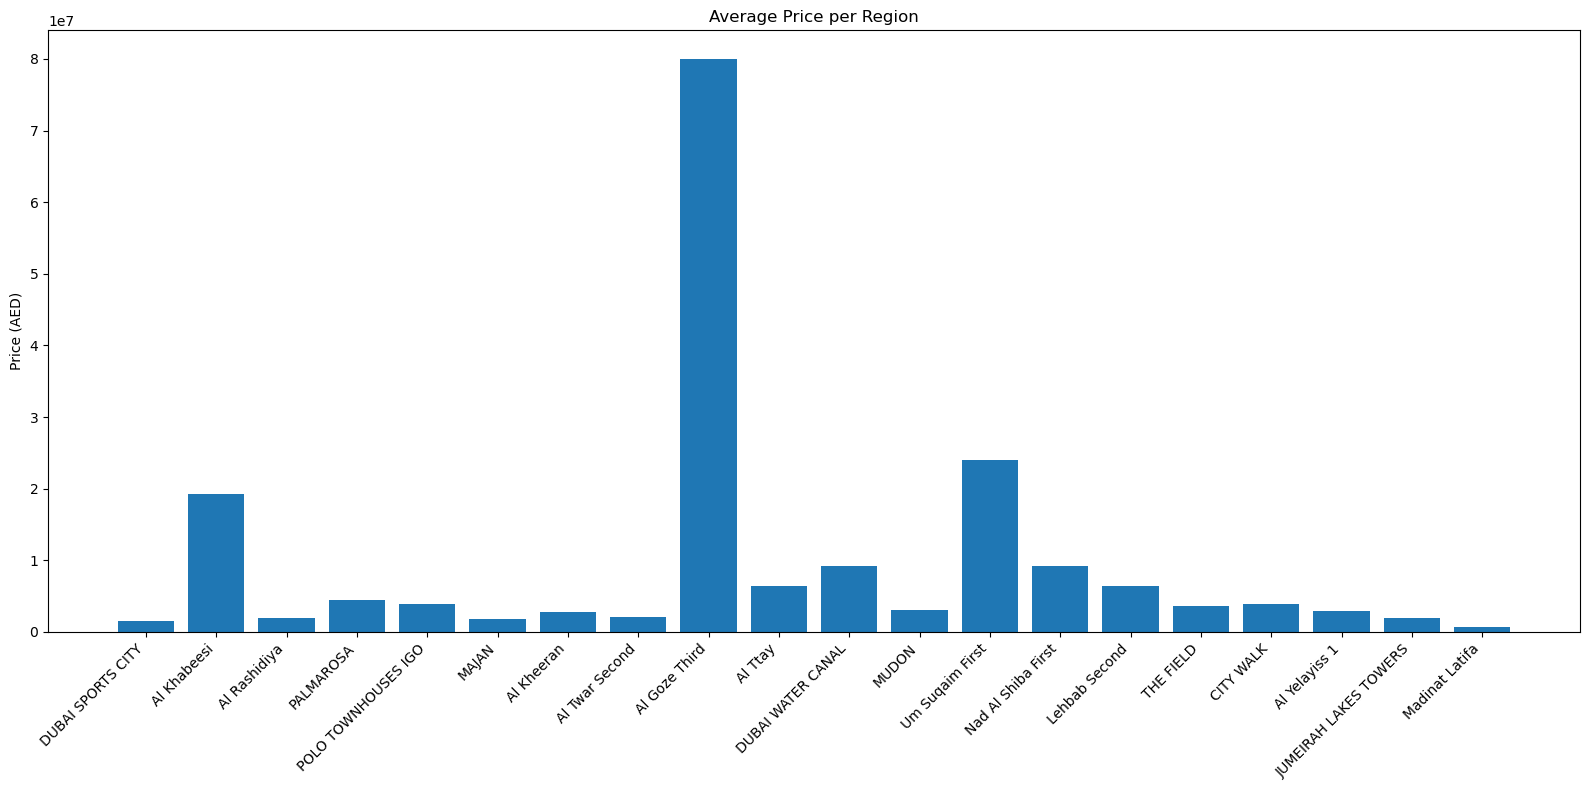

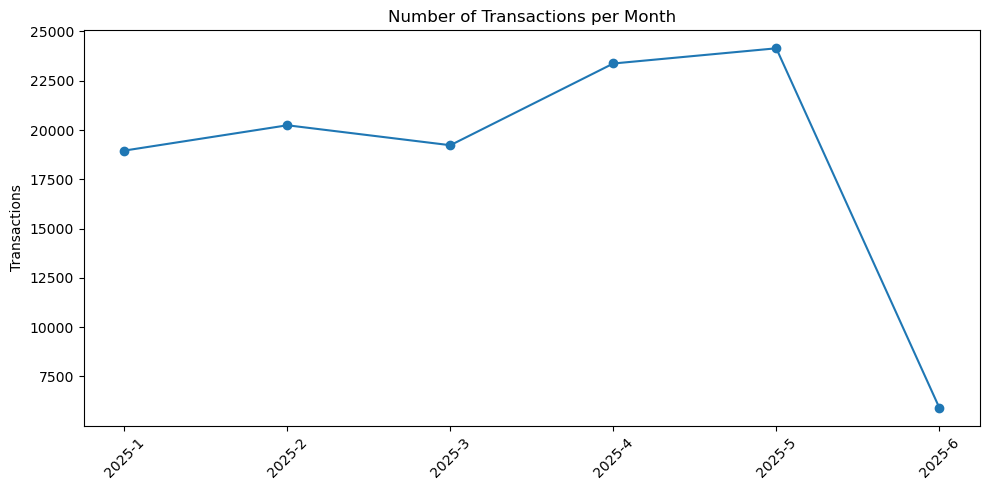

The highest priced property is 
+------------------+--------------------+-----------+----------+------------+
|transaction_number|             area_en|trans_value|  date_col|prop_type_en|
+------------------+--------------------+-----------+----------+------------+
|      13-2556-2025|JUMEIRAH BEACH RE...|  1.57853E9|2025-02-03|        Unit|
+------------------+--------------------+-----------+----------+------------+

The lowest priced property is 
+------------------+-------------+-----------+----------+------------+
|transaction_number|      area_en|trans_value|  date_col|prop_type_en|
+------------------+-------------+-----------+----------+------------+
|      11-4350-2025|SAMA AL JADAF|      10.77|2025-02-03|        Land|
+------------------+-------------+-----------+----------+------------+



In [35]:
analyzed_data = analyze()

In [36]:
spark.stop()